<a href="https://colab.research.google.com/github/Yukik12/conversion/blob/main/conversion%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- label encoding をしたデータは検定や相関係数の精度がよくない→one hot encoding を使う
- クラスタリングを行う際にはlabel encoding したデータを用いる

In [ ]:
!pip install -q japanize_matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

plt.rcParams['figure.figsize'] =10,8

     |████████████████████████████████| 4.1 MB 6.2 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/exercise.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
# 代表値の確認(13)
_df = pd.get_dummies(df)
_df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.149422,0.449625,0.400953,0.121281,0.437828,0.440891,0.334172,0.332922,0.332906
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.356507,0.497460,0.490095,0.326456,0.496123,0.496498,0.471704,0.471263,0.471257
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## データの可視化

- 今回のデータは、質的データ、その中でも名義尺度が多く、代表値を見ても傾向はあまりわからない気がした。
- 割合をとったり、相関係数を見たりして、傾向をつかむのが良い？

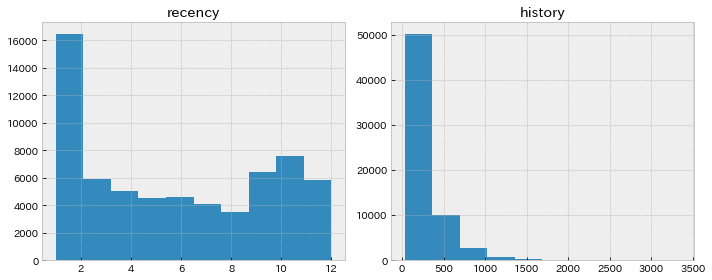

In [ ]:
# 量的データ→ヒストグラム
plt.figure(figsize=(10,4))# 表示指定(10)
plt.subplot(1,2,1)
df['recency'].hist() #ヒストグラム(9)
plt.title('recency')
plt.subplot(1,2,2)
df['history'].hist()
plt.title('history')
plt.tight_layout()

In [ ]:
# 質的データ→円グラフ
def pie_graph(dx,n,contents): # 関数(4)(8)
    plt.subplot(1,7,n) # dx: データ　n:何番目に表示するか
    plt.title(contents)
    contents = dx[contents].value_counts() 
    plt.pie(contents,labels=contents.index,autopct='%.1f%%');

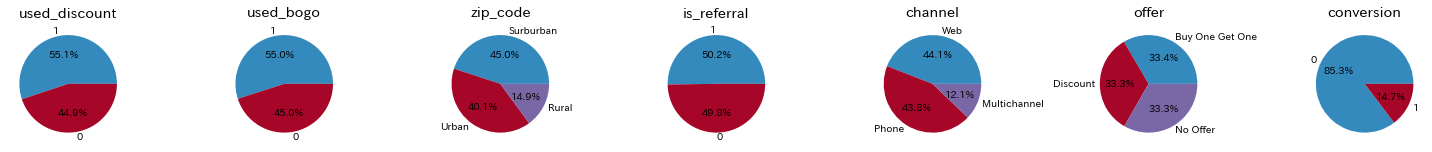

In [ ]:
plt.figure(figsize=(20,4))
contents_set = np.array(['used_discount','used_bogo','zip_code','is_referral','channel','offer','conversion'])

for n in range(7):
  pie_graph(df,n+1,contents_set[n])
plt.tight_layout()

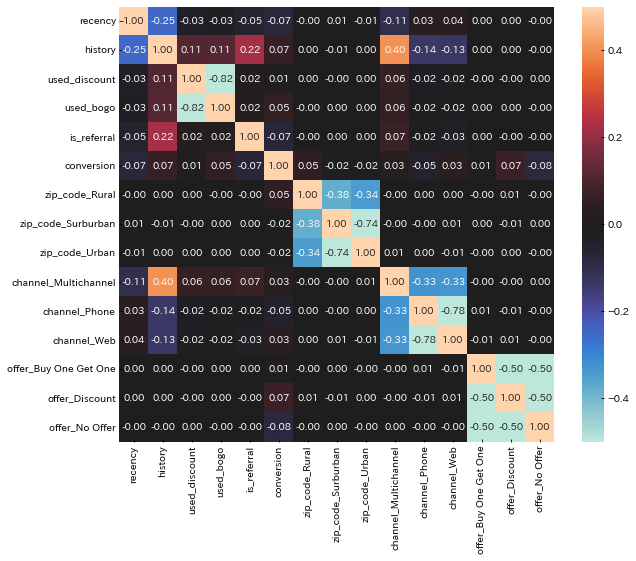

In [ ]:
# 相関関係の確認
sns.heatmap(_df.corr(), annot=True, square=True, vmax=0.5, vmin=-0.5, center=0, fmt='.2f');

- 相関がみられる(関係のありそうなもの)
  - historyとrecency,is_referral,channnel,used_type(discount,bogoのうちどのサービスを利用したか)
  - channelとrecency
  - conversion と recency,history,is_refrral,used_bogo,offer_type

- これらの変数のつながりを確認しconversionに影響を与える元となる変数を探し出す。

## 質的データの確認

In [ ]:
pd.crosstab(df['used_discount'],df['used_bogo'])

used_bogo,0,1
used_discount,,
0,0,28734
1,28818,6448


- bogo と discount を両方使う人たちもいる→両方使う人たちを区別する

In [ ]:
new_df = df.copy().drop(['used_discount','used_bogo'],axis=1) 
condition_list = [(df['used_discount']==1)&(df['used_bogo']==0),(df['used_discount']==0)&(df['used_bogo']==1),(df['used_discount']==1)&(df['used_bogo']==1)]
choice_list = ['discount_only','bogo_only','both']
new_df['used_type'] = np.select(condition_list,choice_list)
new_df.head()

,recency,history,zip_code,is_referral,channel,offer,conversion,used_type
0,10,142.44,Surburban,0,Phone,Buy One Get One,0,discount_only
1,6,329.08,Rural,1,Web,No Offer,0,both
2,7,180.65,Surburban,1,Web,Buy One Get One,0,bogo_only
3,9,675.83,Rural,1,Web,Discount,0,discount_only
4,2,45.34,Urban,0,Web,Buy One Get One,0,discount_only


## new_dfを用いてデータの確認

### one hot encoding で重回帰分析

In [ ]:
new_df_one_encoding = pd.get_dummies(new_df)
new_df_one_encoding.head()

,recency,history,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,used_type_bogo_only,used_type_both,used_type_discount_only
0,10,142.44,0,0,0,1,0,0,1,0,1,0,0,0,0,1
1,6,329.08,1,0,1,0,0,0,0,1,0,0,1,0,1,0
2,7,180.65,1,0,0,1,0,0,0,1,1,0,0,1,0,0
3,9,675.83,1,0,1,0,0,0,0,1,0,1,0,0,0,1
4,2,45.34,0,0,0,0,1,0,0,1,1,0,0,0,0,1


In [ ]:
new_df_numeric = new_df_one_encoding.select_dtypes(include='number')
x_0 = new_df_numeric.drop(['conversion'],axis=1)
y_0 = new_df_numeric['conversion']

In [ ]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled_0 = scaler.fit_transform(x_0)

In [ ]:
feature = pd.DataFrame(x_scaled_0,columns=new_df_numeric.drop(['conversion'],axis=1).columns)
np.random.seed(0)
multi_ols = sm.OLS(y_0,sm.add_constant(feature))
result = multi_ols.fit()

In [ ]:
res_values = pd.DataFrame([result.tvalues[1:],result.pvalues[1:],result.params[1:]],index=['t','p','coef']).T
res_values[(res_values['t'].abs()>2.0)&(res_values['p']<=0.05)].sort_values('t',ascending=False)

,t,p,coef
used_type_both,19.788159,6.858848e-87,0.024843
offer_Discount,18.255100,2.911645e-74,0.016736
zip_code_Rural,12.332145,6.662593e-35,0.013450
channel_Web,10.006692,1.482363e-23,0.008335
history,8.706340,3.211528e-18,0.014495
offer_Buy One Get One,2.564669,1.032970e-02,0.002349
used_type_bogo_only,-3.830962,1.277648e-04,-0.003123
zip_code_Surburban,-5.377037,7.598622e-08,-0.004444
zip_code_Urban,-6.241217,4.368902e-10,-0.005273
channel_Phone,-8.581673,9.555896e-18,-0.007166


- 分析結果
  - is_referral→offer_type→used_type→channel→zip_codeの順に影響がありそう

In [ ]:
result.rsquared_adj

0.034301038563986586

## クラスタリングを行う

In [ ]:
# ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_df_encoding = new_df.copy()
new_df_encoding['zip_code'] = le.fit_transform(new_df_encoding['zip_code'])
new_df_encoding['channel'] = le.fit_transform(new_df_encoding['channel'])
new_df_encoding['offer'] = le.fit_transform(new_df_encoding['offer'])
new_df_encoding['used_type'] = le.fit_transform(new_df_encoding['used_type'])
new_df_encoding.head()

,recency,history,zip_code,is_referral,channel,offer,conversion,used_type
0,10,142.44,1,0,1,0,0,2
1,6,329.08,0,1,2,2,0,1
2,7,180.65,1,1,2,0,0,0
3,9,675.83,0,1,2,1,0,2
4,2,45.34,2,0,2,0,0,2


In [ ]:
x_1 = new_df_encoding.drop(['history','recency','conversion'],axis=1) #量的データを削除
y_1 = new_df_encoding['conversion']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled_1 = scaler.fit_transform(x_1)

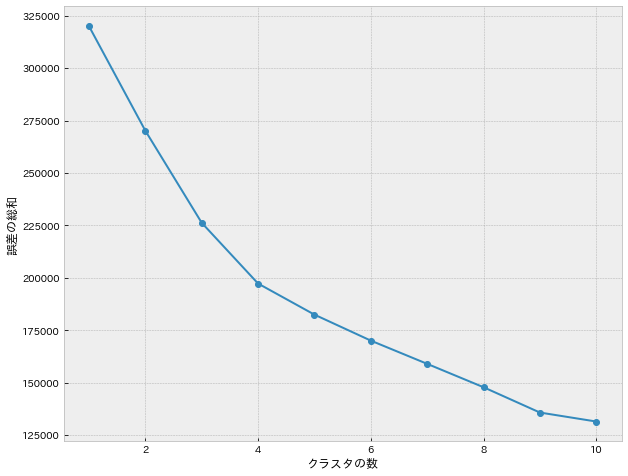

In [ ]:
# エンコーディング（文字列を数字に）したものを使用
from sklearn.cluster import KMeans

sse = []

for i  in range(1,11):                
    kmeans = KMeans(
        n_clusters=i,
        n_init=10,
        random_state=0
        )
    
    kmeans.fit(x_scaled_1)             
    sse.append(kmeans.inertia_)   

plt.plot(range(1,11), sse , marker='o')
plt.xlabel('クラスタの数')
plt.ylabel('誤差の総和')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4,random_state=0)

kmeans.fit(x_scaled_1)

cluster = kmeans.labels_

In [ ]:
df_clustering = new_df.copy() # エンコーディング前の文字ありデータに貼り付け（クラスタリングは数字で行っている）
df_clustering['cluster'] = cluster
df_clustering.head()

,recency,history,zip_code,is_referral,channel,offer,conversion,used_type,cluster
0,10,142.44,Surburban,0,Phone,Buy One Get One,0,discount_only,0
1,6,329.08,Rural,1,Web,No Offer,0,both,1
2,7,180.65,Surburban,1,Web,Buy One Get One,0,bogo_only,1
3,9,675.83,Rural,1,Web,Discount,0,discount_only,2
4,2,45.34,Urban,0,Web,Buy One Get One,0,discount_only,0


In [ ]:
groups = df_clustering.groupby('cluster')

In [ ]:
groups.size() # 等分

cluster
0    16249
1    15391
2    16753
3    15607
dtype: int64

In [ ]:
df_cluster_0 = groups.get_group(0).reset_index(drop=True)
df_cluster_1 = groups.get_group(1).reset_index(drop=True)
df_cluster_2 = groups.get_group(2).reset_index(drop=True)
df_cluster_3 = groups.get_group(3).reset_index(drop=True)

In [ ]:
def hist_1(dx,l,m,n,i,contents):  # l種類のデータのmこのグラフ　n種類目のデータのi個目のグラフ
  plt.subplot(l,m,m*n+i-m)
  sns.distplot(dx[contents],bins=12+(i-1)*30)

In [ ]:
def pie_graph_1(dx,l,m,n,i,contents):
    plt.subplot(l,m,m*n+i-m)
    plt.title(contents)
    contents = dx[contents].value_counts() 
    plt.pie(contents,labels=contents.index,autopct='%.1f%%');

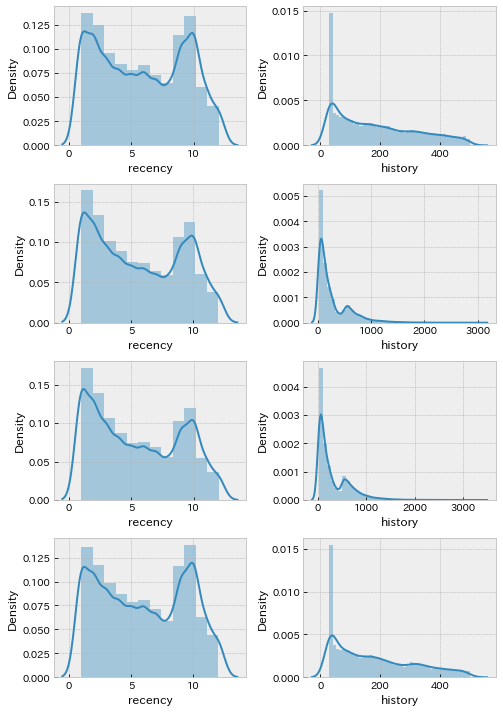

In [ ]:
plt.figure(figsize=(7,10))
dx = np.array([df_cluster_0,df_cluster_1,df_cluster_2,df_cluster_3])
contents = np.array(['recency','history'])
(l,m) = (4,2)

for n in range(l):
  for i in range(m):
    hist_1(dx[n],l,m,n+1,i+1,contents[i])
plt.tight_layout()

- 縦軸のスケールの違いに注意！

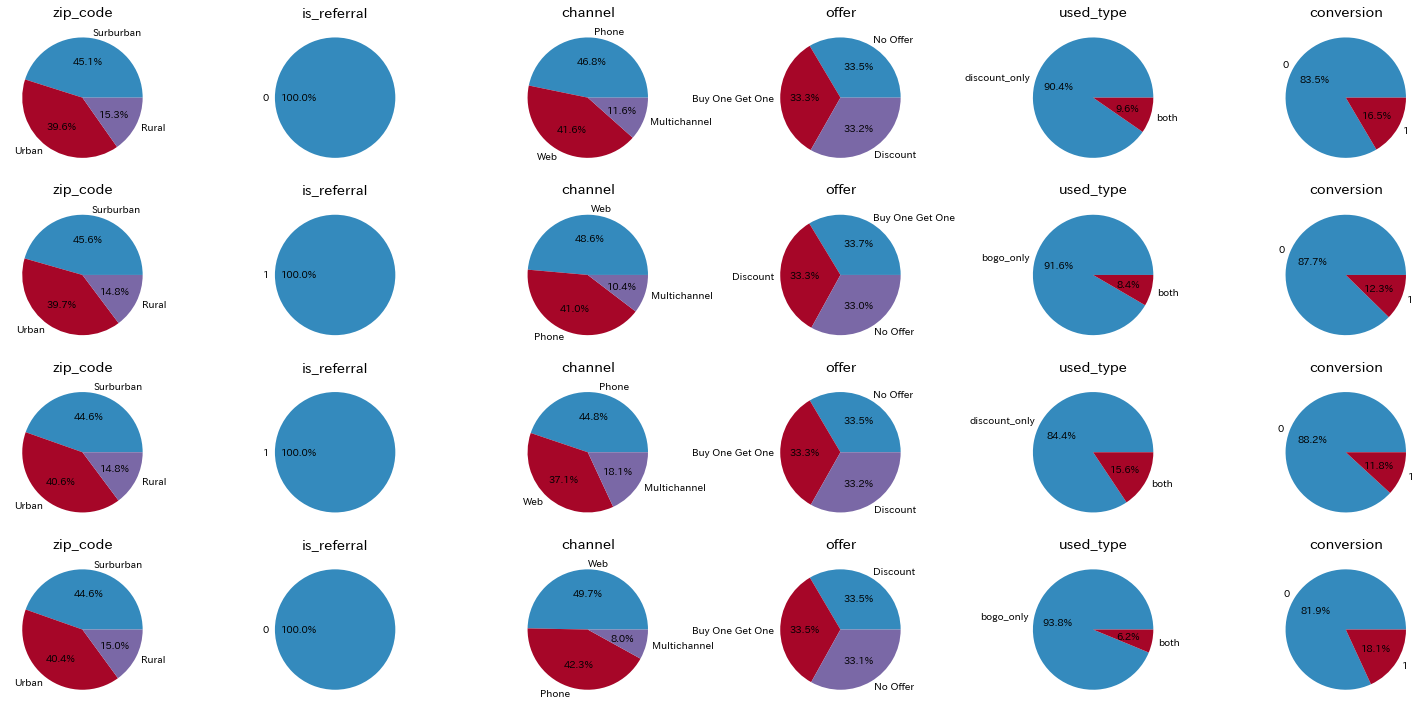

In [ ]:
plt.figure(figsize=(20,10))

contents_1= np.array(['zip_code','is_referral','channel','offer' ,'used_type','conversion'])
(l,m) = (4,6)

for n in range(l):
  for i in range(m):
    pie_graph_1(dx[n],l,m,n+1,i+1,contents_1[i])
plt.tight_layout()

- 質的関数のzip_code,offerに関してはいずれのクラスタも同じ割合
- クラスタ0とクラスタ3、クラスタ１とクラスタの量的関数の分布がそれぞれ似ている
- クラスタ0とクラスタ3
  - 共通点
    - リファラルで流入したわけではない
    - channelがphoneとwebメイン
    - recencyが長い人の割合が大きく、hisutoryも低い人の割合が大きい
  - 相違点
    - discountが多いか、bogoが多いか
- クラスタ1とクラスタ2
  - 共通点
    - リファラルで流入している
    - recencyが短い人のの割合が大きく、hisutoryも高い人の割合が大きい
  - 相違点
    - discountが多いか、bogoが多いか


## conversionの値で比較

In [ ]:
df_cluster_00 = df_cluster_0.query('conversion==0')
df_cluster_01 = df_cluster_0.query('conversion==1')
df_cluster_10 = df_cluster_1.query('conversion==0')
df_cluster_11 = df_cluster_1.query('conversion==1')
df_cluster_20 = df_cluster_2.query('conversion==0')
df_cluster_21 = df_cluster_2.query('conversion==1')
df_cluster_30 = df_cluster_3.query('conversion==0')
df_cluster_31 = df_cluster_3.query('conversion==1')

## conversionの値で比較

### cluster0

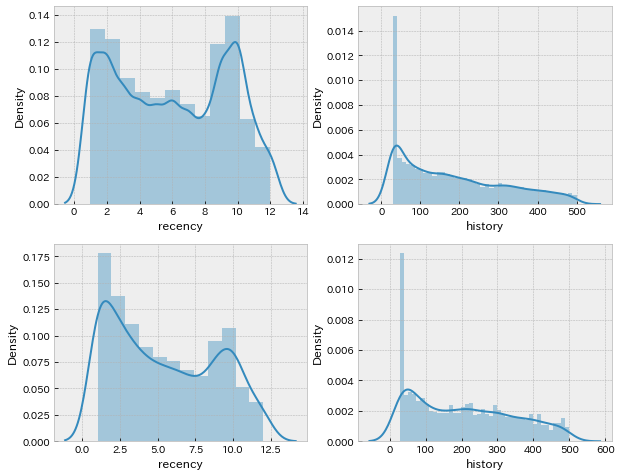

In [ ]:
dx_0 = [df_cluster_00,df_cluster_01]
(l,m) = (2,2)

for n in range(l):
  for i in range(m):
    hist_1(dx_0[n],l,m,n+1,i+1,contents[i])

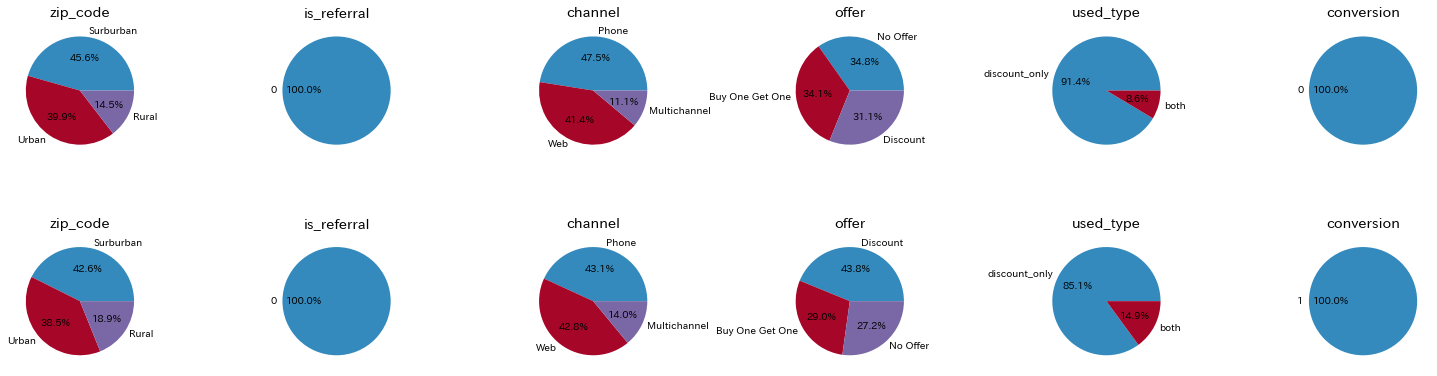

In [ ]:
plt.figure(figsize=(20,6))

(l,m) = (2,6)

for n in range(l):
  for i in range(m):
    pie_graph_1(dx_0[n],l,m,n+1,i+1,contents_1[i])
plt.tight_layout()

- リファラルで流入していない,discount を利用している場合
  - convesionが高い人はDiscountのofferを受けている割合がたかい。一方で、conversionが低い人はdiscountの割合も普通
  - bogoとdiscountの両方を用いた人のほうがconversionが高い
  - Webとmultichannelを使っている人のほうがconversionが高い
  - recencyとhistoryの分布に違いはあるもののcluster1,2とh画すると違いは大きくない
  -Discountが高い方がconversionが高い

### cluster1

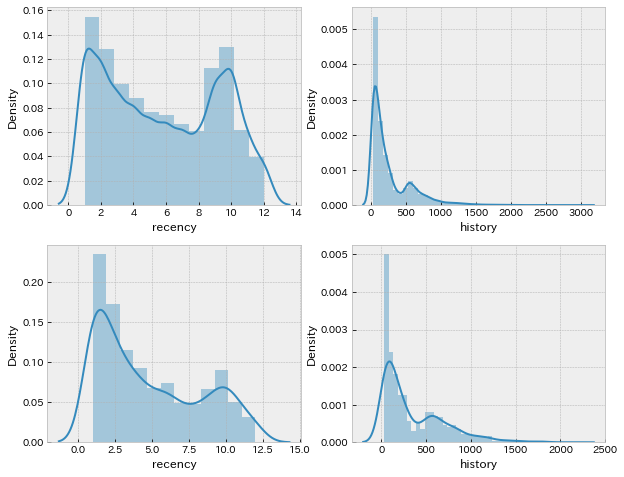

In [ ]:
dx_1 = [df_cluster_10,df_cluster_11]
(l,m) = (2,2)

for n in range(l):
  for i in range(m):
    hist_1(dx_1[n],l,m,n+1,i+1,contents[i])

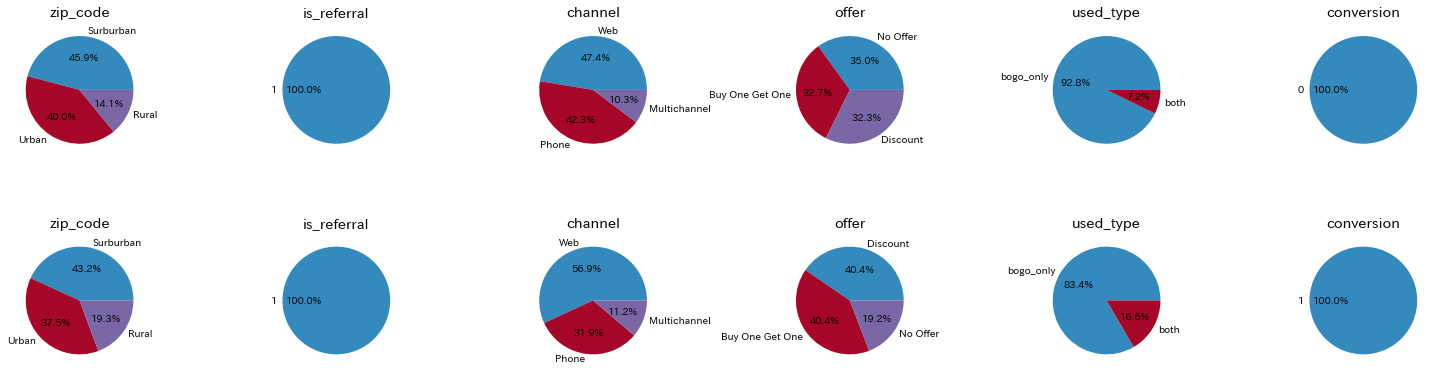

In [ ]:
plt.figure(figsize=(20,6))


(l,m) = (2,6)

for n in range(l):
  for i in range(m):
    pie_graph_1(dx_1[n],l,m,n+1,i+1,contents_1[i])
plt.tight_layout()

- リファラルで流入しており、bogoを利用する場合
  - conversionが高い人はWebを使う人が多い
  - bogo,discount両方用いている人のほうがconversionがたかい
  - nofferの人が少ないほうがconversionが高い
  - recencyは短く、historyは高いほうがconversionが高いことがわかる
  -BuyOneGetOne、Discountが高い方がconversionが高い

### cluster2

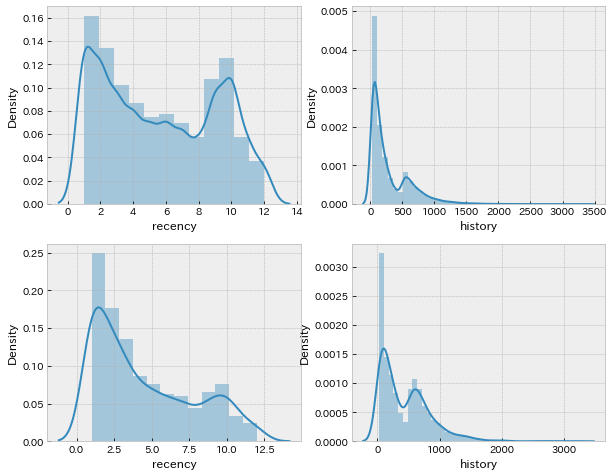

In [ ]:
dx_2 = [df_cluster_20,df_cluster_21]
(l,m) = (2,2)

for n in range(l):
  for i in range(m):
    hist_1(dx_2[n],l,m,n+1,i+1,contents[i])

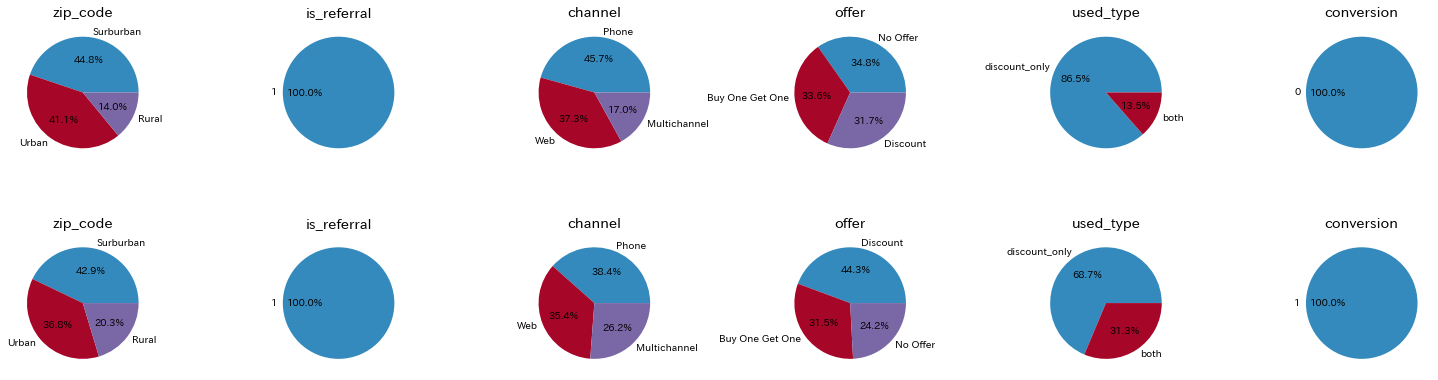

In [ ]:
plt.figure(figsize=(20,6))


(l,m) = (2,6)

for n in range(l):
  for i in range(m):
    pie_graph_1(dx_2[n],l,m,n+1,i+1,contents_1[i])
plt.tight_layout()

- リファラルで流入しており、discountを使う場合
  - conversionが高いほうはMultichannelを使う人の割合が高い
  - discountのオファーを受け取っている人のほうがコンヴァージョンは高い
  - bogo,discount両方使っている人のほうがconversionが高い
  - cluster1と同様、recencyおよびhistoryの違いは大きい

### cluster3

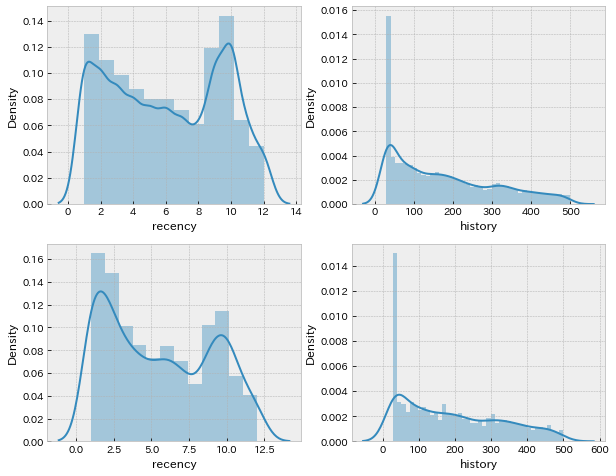

In [ ]:
dx_3 = [df_cluster_30,df_cluster_31]
(l,m) = (2,2)

for n in range(l):
  for i in range(m):
    hist_1(dx_3[n],l,m,n+1,i+1,contents[i])

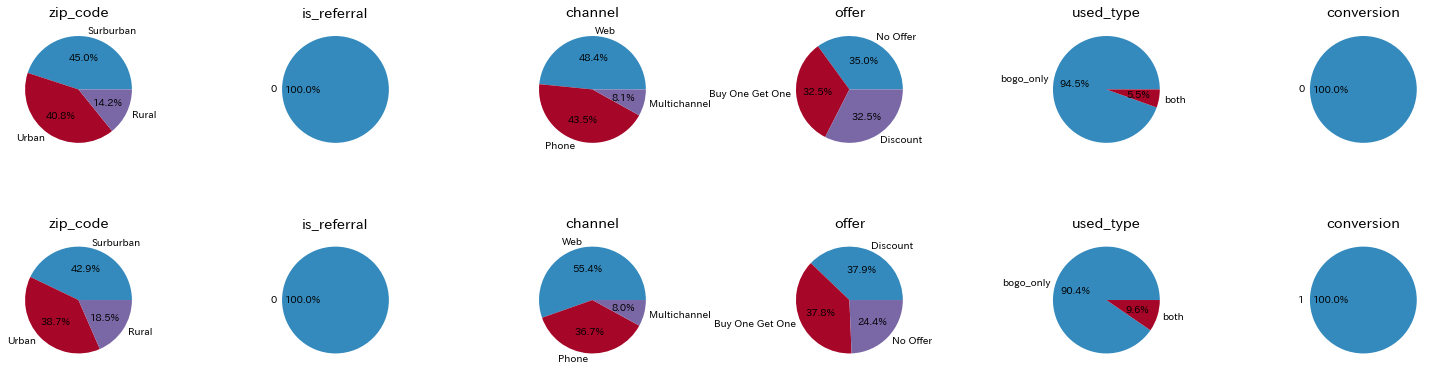

In [ ]:
plt.figure(figsize=(20,6))

(l,m) = (2,6)

for n in range(l):
  for i in range(m):
    pie_graph_1(dx_3[n],l,m,n+1,i+1,contents_1[i])
plt.tight_layout()

- リファラルで流入しておらず、bogoを使う場合
  - webを使う人の割合が大きいほうがconversionは高い
  - discount,bogoのofferを受けているほうがconversionは高い
  - recency,historyに違いは見られるものの、特別大きい違いではない

## 結論

- conversionが高くなる要因は複数あり、それらは複雑に絡み合っている。その要因を特定することは、難しいがconversionが高い人の傾向をつかみその人を抽出することは可能であると考える
- 以下にconversionが高いユーザーの特徴を示す。

1. リファラルで流入していて、bogoとofferを両方とも使う人で前回購入からの月数が短く、過去購入品の価値が高い人

- 1の条件はかなり厳しく、対象人数が少なくて、conversionの確度が高いユーザーが漏れる可能性が高い。
そのためもう少し緩い条件を示す。ただし、精度は低くなる。

2. Webまたは、Multichannelを利用していて、bogoとofferを両方とも使う人で、前回購入からの月数が短く過去の購入品の価値が高い人

- さらに大雑把に考える

3. 前回購入からの月数が短く、過去購入品の価値が高い人

- オファータイプもconversionに影響を与えていると考えるが、どのようなときにどのような条件を満たした場合にオファーがもらえるのかデータがわからないため、判定が不可能。
これらを調査することで、より精度の高い分析ができると考える。

## どれくらいの精度か、今回のデータを用いて確認

In [ ]:
# recency及びhistoryの平均値を確認→判断の基準とする
df['recency'].mean()

5.763734375

In [ ]:
df['history'].mean()

242.08565578127568

In [ ]:
# 条件1，2，3をそれぞれ定義する condition_listの()の中の条件を変えれば、円グラフも変わります！
check_se = new_df_one_encoding.copy() 
condition_list_1 = [(check_se['is_referral']==1)&(check_se['used_type_both']==1)&(check_se['recency']<check_se['recency'].mean())&(check_se['history']>check_se['history'].mean())]
choice_list_1 = [1]
check_se['check_type_1'] = np.select(condition_list_1,choice_list_1)

condition_list_2 = [(check_se['channel_Phone']==0)&(check_se['recency']<check_se['recency'].mean())&(check_se['history']>check_se['history'].mean())&(check_se['recency']<check_se['recency'].mean())&(check_se['history']>check_se['history'].mean())]
choice_list_2 = [1]
check_se['check_type_2'] = np.select(condition_list_2,choice_list_2)

condition_list_3 = [(check_se['recency']<check_se['recency'].mean())&(check_se['history']>check_se['history'].mean())]
choice_list_3 = [1]
check_se['check_type_3'] = np.select(condition_list_3,choice_list_3)

#offer_Discountを受け、前回購入からの月数が短い
condition_list_4 = [(check_se['offer_Discount']==1)&(check_se['recency']<check_se['recency'].mean())]
choice_list_4 = [1]
check_se['check_type_4'] = np.select(condition_list_4,choice_list_4)

condition_list_5 = [(check_se['offer_Buy One Get One']==1)&(check_se['recency']<check_se['recency'].mean())]
choice_list_5 = [1]
check_se['check_type_5'] = np.select(condition_list_5,choice_list_5)


check_df = pd.DataFrame(check_se)
check_df

,recency,history,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,...,offer_Discount,offer_No Offer,used_type_bogo_only,used_type_both,used_type_discount_only,check_type_1,check_type_2,check_type_3,check_type_4,check_type_5
0,10,142.44,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,6,329.08,1,0,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,7,180.65,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,9,675.83,1,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,2,45.34,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,0,0,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,0
63996,5,38.91,1,0,0,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
63997,6,29.99,1,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
63998,1,552.94,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,1,0,1


In [ ]:
groups_check_1 = check_df.groupby('check_type_1')
groups_check_2 = check_df.groupby('check_type_2')
groups_check_3 = check_df.groupby('check_type_3')
groups_check_4 = check_df.groupby('check_type_4')
groups_check_5 = check_df.groupby('check_type_5')

groups_check_accuracy = check_df.groupby('conversion')

In [ ]:
groups_check_1.size()  # 対象は1割未満

check_type_1
0    61524
1     2476
dtype: int64

In [ ]:
groups_check_2.size() # 対象が1割強

check_type_2
0    54822
1     9178
dtype: int64

In [ ]:
groups_check_3.size() # 対象は2割弱

check_type_3
0    50124
1    13876
dtype: int64

In [ ]:
groups_check_4.size() # 対象は1割ちょっと

check_type_4
0    53378
1    10622
dtype: int64

In [ ]:
groups_check_5.size() # 対象は1割ちょっと

check_type_5
0    53318
1    10682
dtype: int64

In [ ]:
df_check_1 = groups_check_1.get_group(1).reset_index(drop=True)
df_check_2 = groups_check_2.get_group(1).reset_index(drop=True)
df_check_3 = groups_check_3.get_group(1).reset_index(drop=True)
df_check_4 = groups_check_4.get_group(1).reset_index(drop=True) # 各グループの条件に合う人
df_check_5 = groups_check_5.get_group(1).reset_index(drop=True)

df_check_accuracy = groups_check_accuracy.get_group(1).reset_index(drop=True) # conversionが１の人

In [ ]:
def pie_graph_check_accuracy(dx,l,m,n,contents): 
    
    plt.subplot(l,m,3*n-2)
    plt.title('ratio')
    contents_0 = check_df[contents].value_counts()
    plt.pie(contents_0,labels=contents_0.index,autopct='%.1f%%')


    plt.subplot(l,m,3*n-1)
    plt.title('conversion')
    contents_1 = dx['conversion'].value_counts() 
    plt.pie(contents_1,labels=contents_1.index,autopct='%.1f%%')
   

    plt.subplot(l,m,3*n)
    plt.title('convrsion_accuracy')
    contents_2 = df_check_accuracy[contents].value_counts()
    plt.pie(contents_2,labels=contents_2.index,autopct='%.1f%%')
   

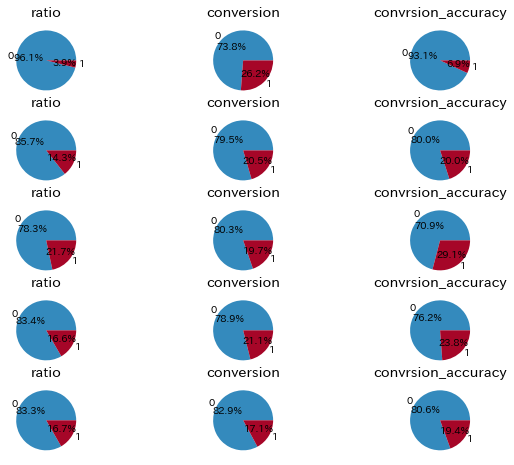

In [ ]:
dx_4 = [df_check_1,df_check_2,df_check_3,df_check_4,df_check_5]
contents = ['check_type_1','check_type_2','check_type_3','check_type_4','check_type_5']
(l,m) = (5,3)


for n in range(l):
    pie_graph_check_accuracy(dx_4[n],l,m,n+1,contents[n])
    

# 1番左：全体の何割の人にプロモーションを行うか
# 左から2番目：プロモーションをかけた人のうち確度が高い人は何割か
# 左から3番目：確度の高い人のうちプロモーションをかけた人は何割か

- この結果から条件２が最もコストパフォーマンスがいいと思う
- もう少し精度を高めることができるはず

- conversionを高める必要はあるのか？
- 